<a href="https://colab.research.google.com/github/cappelchi/Modeling-Precision-Medicine/blob/master/Modeling_Precision_Medicine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<u>Content</u>:

[- Task](#scrollTo=hnkyl0KK7EBE)

[- Background](#scrollTo=5okWuAiR7LkR)

[- Some installations, setup and predifinitions](#scrollTo=bqX0DAWm4oNB)

[- Results and discussion](#scrollTo=oJjFVIGF8NsR)

## Task

Below are links to the raw gene expression table resulting from the RNA-seq pipeline, as well as the unprocessed drug efficacy table. The large number of samples adds potential for more discovery. You may use your own tools, or those available on the T-BioInfo platform.

Data: CellLines_Student_ProjectData

The files contained in the zipped folder are:

CellLines_ClinSubtypes.txt – a list of the samples with their known PAM50 subtypes

CellLines_ExprData.txt – expression data from the RNA-seq pipeline as detailed in section 3; 52 breast cancer samples

CellLines_DrugsInit.txt – unprocessed drug efficacy (GI50) table; missing data

CellLines_DrugsRes.txt – process drug efficacy (GI50) table; missing data approximated.


**Results** should be presented in the format of a poster. See the template below, which contains important sections to include.

*Background*: Biological/computational concepts and problem statement

*Methods*: Experimental design, samples and data types, pipelines

*Results and Discussion*: Statistical conclusions, key findings (genes, etc.), biological interpretation, limitations to the analysis, future research

*Conclusion*: Short summary of results
References

The same sections are typically used in a research paper. Following these guidelines you would be ready to present your results.

**Prediction of the most effective therapeutic agent, given the expression data from a tumor sample.*** 

This could be done by assigning to each sample it’s most effective therapeutic agent (from the Gi50 data) as its “class”, then using a model in the supervised analysis section to learn to “classify” the data.
Using supervised analysis modules that perform feature selection (such as swLDA or RandForest), to determine which genes are most informative for predicting best therapeutic agent.
Performing more extensive clustering analysis to determine distinct breast cancer sub-types based on gene or isoform expression.
[Modeling precision treatment of breast cancer](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3937590/)

[Биологические принципы метастазирования](https://medach.pro/post/2267)

Associated Publication and Dataset
The course uses data presented by Daemen et al. (Modeling precision treatment of breast cancer, Genome Biol. 2013. The researchers tested 90 therapeutic compounds on 70 breast cancer cell lines (out of 84 lines comprising their collection) and determined GI50 — concentrations required to inhibit cell growth by 50%. GI50 can be treated as a measure of efficacy of a given compound for a given breast cancer cell line. In addition to a table with GI50 values, Daemen et al. deposited results of RNA-Seq (GSE4821) for 56 cell lines, including 52 for which GI50 data was also available. Finally, the authors specified an associated breast cancer subtype for each cell line. For this course, we will be using data from those 52 cell lines for which GI50 data was available.



##Background


Breast cancer is a clinically and genomically heterogeneous disease. Six subtypes (4 in our dataset) were defined approximately a decade ago based on transcriptional characteristics and were designated luminal A, luminal B, basal-like, claudin-low and normal-like.
In breast cancer, cell lines mirror many of the molecular characteristics of the tumors from which they were derived, and are therefore a useful preclinical model in which to explore strategies for predictive marker development.

##Some installations, setup and predifinitions

In [0]:
import sys
import pandas as pd
from tqdm import tqdm

In [0]:
import plotly.graph_objects as go
import plotly.figure_factory as ff
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)

In [0]:
!test -d Modeling-Precision-Medicine || git clone https://github.com/cappelchi/Modeling-Precision-Medicine.git
if not 'Modeling-Precision-Medicine' in sys.path:
  sys.path += ['Modeling-Precision-Medicine']
!ls Modeling-Precision-Medicine

Cloning into 'Modeling-Precision-Medicine'...
remote: Enumerating objects: 106, done.
remote: Total 106 (delta 0), reused 0 (delta 0), pack-reused 106
Receiving objects: 100% (106/106), 24.65 MiB | 28.95 MiB/s, done.
Resolving deltas: 100% (44/44), done.
CellLines_ClinSubtypes.txt	   img				      models
CellLines_Student_ProjectData.zip  Modeling_Precision_Medicine.ipynb  README.md


In [0]:
mypath = '/content/Modeling-Precision-Medicine/'

In [0]:
#!wget https://raw.githubusercontent.com/cappelchi/Modeling-Precision-Medicine/master/CellLines_Student_ProjectData.zip
!unzip /content/Modeling-Precision-Medicine/CellLines_Student_ProjectData.zip -d {mypath}

In [0]:
from os import listdir
from os.path import isfile, join
import codecs
import numpy as np

In [0]:
def plot_heatmap(z, labels = ['Basal', 'Claudin-low', 'Luminal', 'Normal-like']):
    enable_plotly_in_cell()
    xlabels = labels
    ylabels = [xlabels[len(xlabels) - 1 - y] for y in range(len(xlabels))]
    fig = ff.create_annotated_heatmap(
                        x = xlabels,
                        y = ylabels,
                        z = np.flipud(z),
                        #text = np.rot90(z),
                        annotation_text = np.flipud(z),
                        colorscale = 'Viridis',
                        showscale = True
    )
    fig.update_layout(
                    title=dict(
                            text = '<br><i>Model confusion matrix</i>',
                            y = 0.95,
                            x = 0.5,
                            xanchor = 'center',
                            yanchor = 'top'
                                ),

                        height = 500,
                        width = 500
    )                  
    fig.show()

In [0]:
def pca_visualization(df, smallg = False, model_class = [], chart_studio = False, chart_name = 'Modeling Breast Cancer Precision Medicine' ):
    enable_plotly_in_cell()
    trs = df.columns[-1]
    annotations =[]
    if model_class:
        add_cls = 1
        df = df.join(pd.DataFrame(model_class, columns = ['model'], index = df.index), how = 'outer')
    else:
        df['model'] = df[trs]
    df = df.sort_values(by = trs)
    for n in df.index:
        if df.loc[n, trs] != df.loc[n, 'model']:
            annotations.append(dict(
                x = n,
                y = 0,
                xref = 'x',
                yref = 'y',
                text = df.loc[n, 'model'],
                textangle = 90,
                bgcolor = 'rgb(255, 0, 0)',
                font = dict(color = 'rgb(255, 255 , 255)'),
                showarrow = True,
                arrowhead = 7,
                ax = 0,
                ay = 40
            ))                
        elif (df.loc[n, trs] == 'Normal-like') or (df.loc[n, trs] == 'Claudin-low'):
            if smallg:
                annotations.append(dict(
                    x = n,
                    y = 0,
                    xref = 'x',
                    yref = 'y',
                    text = df.loc[n, trs],
                    textangle = 90,
                    showarrow = True,
                    arrowhead = 7,
                    ax = 0,
                    ay = 40
                )) 
    fig = go.Figure()

    for comp in df.columns[:-2]:
        fig.add_trace(go.Bar(
            x = df.index, # + df.sort_values(by = 'Transcriptional_subtype').Transcriptional_subtype,
            y = df.loc[:,comp] - df.loc[:,comp].min(),
            name = comp, 
            text = df[trs]
        ))
    fig.update_layout(barmode='stack',
                        title=dict(
                            text = '<br><i>PCA components of Gene Expression</i>',
                            y = 0.95,
                            x = 0.5,
                            xanchor = 'center',
                            yanchor = 'top'
                                ),
                        height = 1000,
                        width = 1600,
                        annotations = annotations
                        )
    fig.show()
    if chart_studio:
        studio.plot(fig, filename = chart_name, auto_open=True)

In [0]:
filespath = '/content/Modeling-Precision-Medicine/CellLines_Student_ProjectData/'
results = [f for f in listdir(filespath) if isfile(join(filespath, f))]

##Results and discussion

###Data: CellLines_Student_ProjectData



Here assembled a collection of 52 breast cancer cell lines composed of 27 luminal, 14 basal, 6 claudin-low, 5 normal-like.

The cells were treated in triplicate with nine different concentrations of each compound. The concentration required to inhibit growth by 50% (GI50) was used as the response measure for each compound.

The files contained in the zipped folder are:

CellLines_ClinSubtypes.txt – a list of the samples with their known PAM50 subtypes

CellLines_ExprData.txt – expression data from the RNA-seq pipeline as detailed in section 3; 52 breast cancer samples

CellLines_DrugsInit.txt – unprocessed drug efficacy (GI50) table; missing data

CellLines_DrugsRes.txt – process drug efficacy (GI50) table; missing data approximated.

In [0]:
results

['CellLines_ClinSubtypes.txt',
 'CellLines_DrugsRes.txt',
 'CellLines_DrugsInit.txt',
 'CellLines_ExprData.txt']

In [0]:
for result in results:
    if result[:10] == 'CellLines_':
        df_name = result[10:-4]
    else:
        df_name = result[:-4]
    comand = f'{df_name} = pd.read_csv("{filespath + result}", sep = "\s+"' + ', dtype={"id":"str"})'
    print (comand)
    exec(comand)
    print (df_name)
    #exec(f'print ({df_name}.describe())')

ClinSubtypes = pd.read_csv("/content/Modeling-Precision-Medicine/CellLines_Student_ProjectData/CellLines_ClinSubtypes.txt", sep = "\s+", dtype={"id":"str"})
ClinSubtypes
DrugsRes = pd.read_csv("/content/Modeling-Precision-Medicine/CellLines_Student_ProjectData/CellLines_DrugsRes.txt", sep = "\s+", dtype={"id":"str"})
DrugsRes
DrugsInit = pd.read_csv("/content/Modeling-Precision-Medicine/CellLines_Student_ProjectData/CellLines_DrugsInit.txt", sep = "\s+", dtype={"id":"str"})
DrugsInit
ExprData = pd.read_csv("/content/Modeling-Precision-Medicine/CellLines_Student_ProjectData/CellLines_ExprData.txt", sep = "\s+", dtype={"id":"str"})
ExprData


In [0]:
ClinSubtypes.groupby(by = 'Transcriptional_subtype').count()

Cell_line
Transcriptional_subtype           
Basal                           14
Claudin-low                      6
Luminal                         27
Normal-like                      5

In [0]:
print ('ClinSubtypes: ', np.shape(ClinSubtypes), 'ExprData: ', np.shape(ExprData),
       'DrugsInit: ', np.shape(DrugsInit), 'DrugsRes: ', np.shape(DrugsRes))

ClinSubtypes:  (52, 2) ExprData:  (6916, 53) DrugsInit:  (84, 91) DrugsRes:  (90, 53)


In [0]:
ExprData = ExprData.rename(columns = {'T47D_Kbluc':'T47D_KBluc'}).set_index('id').T
DrugsRes = DrugsRes.set_index('Cell_line').T
ClinSubtypes = ClinSubtypes.set_index('Cell_line')

In [0]:
!pip install umap-learn
!pip install pycaret

In [0]:
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from umap import UMAP

##Results
1. Cell line classification with [PCA 20](#scrollTo=9H7NUlumM1fC) components of gene expression + Linear Discriminant Analysis - 40 samples train & 12 samples test split: all samples were classified correctly. Accuracy = 100%.
2. Cell line classification with [PCA 4](#scrollTo=oX0H_4CENCH2) components of gene expression + Linear Discriminant Analysis - 40 samples train & 12 samples test split: all samples were classified correctly. Accuracy = 100%.



###UMAP
First we make full dimensional visualization of gene expression with UMAP. 4 classes are identified.

In [0]:
model = UMAP(n_neighbors = 15, min_dist = 0.25, n_components = 2, verbose = True)
umap = model.fit_transform(ExprData)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.25, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Sun May  3 11:00:45 2020 Finding Nearest Neighbors
Sun May  3 11:00:47 2020 Finished Nearest Neighbor Search
Sun May  3 11:00:50 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	complete

In [0]:
label_encoder = preprocessing.LabelEncoder()

In [0]:
enable_plotly_in_cell()
fig = go.Figure(data=go.Scatter(
    x=umap[:, 0],
    y=umap[:, 1],
    mode='markers',
    hovertext = ClinSubtypes.Transcriptional_subtype,
    marker=dict(
                size=10,
                color = label_encoder.fit_transform(ClinSubtypes.Transcriptional_subtype)
                )
))
fig.update_layout(width = 1000,
                  height = 800,
                  title=dict(
                    text = '<br><i>UMAP of full gene expression</i>',
                    y = 0.95,
                    x = 0.5,
                    xanchor = 'center',
                    yanchor = 'top'
                        ),
                  xaxis = dict(
                      title = '<br> Colors: orange - Luminal, blue - Basal, Violet - Claudin-low, yellow - Normal-like'
                               )

                  )
fig.show()

<img src="https://github.com/cappelchi/Modeling-Precision-Medicine/blob/master/img/umap.png?raw=true" width="800" height="600" />

### PCA
Now we need to reduce the dimension of the expression vector with pca. In fact, then you can visually recognize some cell line patterns.

(see [here pca 20](#scrollTo=0MPVcY6XOeaX) and [here pca 4](#scrollTo=12FM8p7qecmg))

In [0]:
pca = PCA(n_components = 20)
principalComponents = pca.fit_transform(ExprData)
pca_clmn = ['pca' + str(i) for i in range(np.shape(principalComponents)[1])]
ExprData_T_pca_labeled = pd.DataFrame(
    data = principalComponents,
    index = ExprData.index,
    columns = pca_clmn)
ExprData_T_pca_labeled = ExprData_T_pca_labeled.join(ClinSubtypes, how = 'outer')

In [0]:
pca_visualization(ExprData_T_pca_labeled, smallg = True)

<img src="https://github.com/cappelchi/Modeling-Precision-Medicine/blob/master/img/pca20.png?raw=true" width="1000" height="600" />

### Installing PyCaret
PyCaret help us to define best model ensambling to classify cell lines.

In [0]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode activated.


##PCA = 20


In [0]:
from pycaret.classification import *

In [0]:
exp_class = setup(data = ExprData.join(ClinSubtypes, how = 'outer'), 
                  target = 'Transcriptional_subtype', 
                  session_id = 123,
                  normalize = True, 
                  transformation = True, 
                  #ignore_low_variance = True,
                  #remove_multicollinearity = True, 
                  #multicollinearity_threshold = 0.95,
                  pca = True, 
                  pca_components = 20,
                  train_size = 0.78,
                  #ignore_features = ['index'],
                  silent = True
                  ) #'GSK2126458'

 
Setup Succesfully Completed!


In [0]:
ts = {0:'Basal', 1:'Claudin-low', 2:'Luminal', 3:'Normal-like'}
labels = ['Basal', 'Claudin-low', 'Luminal', 'Normal-like']

In [0]:
compare_models(fold = 4)

In [0]:
ld_model  = create_model(
                          'lda', 
                          fold = 4, 
                          #ensemble = True,
                          #method = 'Bagging'
                          )

Accuracy  AUC  Recall   Prec.      F1   Kappa
0        0.900  0.0  0.9583  0.9333  0.9055  0.8387
1        1.000  0.0  1.0000  1.0000  1.0000  1.0000
2        0.700  0.0  0.8500  0.8500  0.6857  0.5714
3        0.900  0.0  0.9500  0.9500  0.9111  0.8529
Mean     0.875  0.0  0.9396  0.9333  0.8756  0.8158
SD       0.109  0.0  0.0551  0.0540  0.1158  0.1546

In [0]:
tuned_lda = tune_model('lda', 
                       fold = 4,
                       #ensemble = True,
                       #method = 'Bagging'                      
                       )

Accuracy  AUC  Recall   Prec.      F1   Kappa
0         0.90  0.0   0.750  0.8333  0.8600  0.8246
1         1.00  0.0   1.000  1.0000  1.0000  1.0000
2         0.90  0.0   0.750  0.8250  0.8571  0.8387
3         1.00  0.0   1.000  1.0000  1.0000  1.0000
Mean      0.95  0.0   0.875  0.9146  0.9293  0.9158
SD        0.05  0.0   0.125  0.0855  0.0707  0.0843

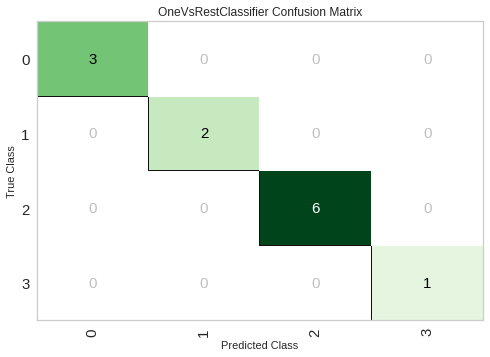

Basal(0)-14; Claudin(1)-6; Luminal(2)-27; Normal(3)-5


In [0]:
plot_model(tuned_lda, plot = 'confusion_matrix')
print('Basal(0)-14; Claudin(1)-6; Luminal(2)-27; Normal(3)-5')

In [0]:
model_class = [ts[int(cls)] for cls in predict_model(tuned_lda, data = ExprData)['Label']]
z = confusion_matrix(model_class, ExprData_T_pca_labeled.Transcriptional_subtype, labels = labels)
plot_heatmap(z)

<img src="https://github.com/cappelchi/Modeling-Precision-Medicine/blob/master/img/heatmap_class.png?raw=true" width="400" height="400" />

In [0]:
final_lda = finalize_model(tuned_lda)

In [0]:
final_lda

OneVsRestClassifier(estimator=LinearDiscriminantAnalysis(n_components=None,
                                                         priors=None,
                                                         shrinkage=0.7,
                                                         solver='eigen',
                                                         store_covariance=False,
                                                         tol=0.0001),
                    n_jobs=None)

In [0]:
# save a model
save_model(tuned_lda, 'lda_model_class_pca20')

Transformation Pipeline and Model Succesfully Saved


##PCA=4

In [0]:
pca = PCA(n_components = 4)
principalComponents4 = pca.fit_transform(ExprData)
pca_clmn = ['pca' + str(i) for i in range(np.shape(principalComponents4)[1])]
ExprData_T_pca4 = pd.DataFrame(
    data = principalComponents4,
    index = ExprData.index,
    columns = pca_clmn)
ExprData_T_pca_labeled4 = ExprData_T_pca4.join(ClinSubtypes, how = 'outer')

In [0]:
pca_visualization(ExprData_T_pca_labeled4, smallg = True)

<img src="https://github.com/cappelchi/Modeling-Precision-Medicine/blob/master/img/pca4.png?raw=true" width="1000" height="800" />

##Drug Response

###Select Drugs

In [0]:
DrugsRes_idx = pd.DataFrame().reindex_like(DrugsRes)

In [0]:
for mx in DrugsRes.index:
    DrugsRes_idx.loc[mx] = sorted(range(len(DrugsRes.loc[mx])), 
                 key=lambda k: (sorted(range(len(DrugsRes.loc[mx])), 
                                       key=lambda k1: DrugsRes.loc[mx][k1]))[k])

In [0]:
DrugsRes_idx = DrugsRes_idx.join(ClinSubtypes, how ='outer')

In [0]:
DrugsRes_idx.loc[DrugsRes_idx['Transcriptional_subtype'] == 'Basal', :'Transcriptional_subtype'].sum()[:-1].sort_values(ascending = False)[:10]

Docetaxel       1217
Paclitaxel      1181
GSK2126458      1178
Ixabepilone     1175
Bortezomib      1164
Velcade         1139
Geldanamycin    1119
Ispinesib       1103
Vinorelbine     1094
GSK461364       1078
dtype: object

In [0]:
DrugsRes_idx.loc[DrugsRes_idx['Transcriptional_subtype'] == 'Claudin-low', :'Transcriptional_subtype'].sum()[:-1].sort_values(ascending = False)[:10]

Docetaxel       529
Ixabepilone     520
Vinorelbine     512
Paclitaxel      509
Bortezomib      502
Velcade         494
Geldanamycin    487
GSK461364       485
GSK2126458      467
Ispinesib       464
dtype: object

In [0]:
DrugsRes_idx.loc[DrugsRes_idx['Transcriptional_subtype'] == 'Luminal', :'Transcriptional_subtype'].sum()[:-1].sort_values(ascending = False)[:10]

GSK2126458      2336
Docetaxel       2307
Paclitaxel      2242
Geldanamycin    2167
Bortezomib      2162
Velcade         2158
Ixabepilone     2088
Vinorelbine     2066
PF.4691502      2010
17.AAG          1995
dtype: object

In [0]:
DrugsRes_idx.loc[DrugsRes_idx['Transcriptional_subtype'] == 'Normal-like', :'Transcriptional_subtype'].sum()[:-1].sort_values(ascending = False)[:10]

GSK2126458      434
GSK1120212      430
Geldanamycin    427
Paclitaxel      415
Docetaxel       406
17.AAG          403
Vinorelbine     401
Bortezomib      398
Ixabepilone     398
MG.132          392
dtype: object

In [0]:
#10 Best Drugs
b_drugs = ['Docetaxel', 'GSK2126458', 'Paclitaxel']

In [0]:
from pycaret.regression import *

### Docetaxel


In [0]:
exp_regr = setup(data = ExprData.join(DrugsRes.Docetaxel, how = 'outer'), 
                  target = 'Docetaxel', 
                  session_id = 123,
                  normalize = True, 
                  transformation = True, 
                  #ignore_low_variance = True,
                  #remove_multicollinearity = True, 
                  #multicollinearity_threshold = 0.95,
                  pca = True, 
                  pca_components = 4,
                  train_size = 0.78,
                  #ignore_features = ['index'],
                  #feature_selection = True,
                  #feature_selection_threshold = 0.8,
                  silent = True
                  )

 
Setup Succesfully Completed!


In [0]:
compare_models(fold = 4)

In [0]:
lr_model = create_model(
    'lr', 
    fold = 4,
    #ensemble = True,
    #method = 'Bagging'
    )

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.2093  0.0647  0.2543  0.5205  0.0277  0.0257
1     0.3501  0.1821  0.4267  0.0985  0.0475  0.0438
2     0.1980  0.0497  0.2230  0.4036  0.0240  0.0241
3     0.2593  0.0921  0.3036  0.4201  0.0328  0.0310
Mean  0.2542  0.0972  0.3019  0.3607  0.0330  0.0311
SD    0.0600  0.0513  0.0776  0.1578  0.0089  0.0077

In [0]:
tune_lr = tune_model(
    'lr', 
    fold = 4,
    #n_iter = 100,
    ensemble = True,
    method = 'Bagging'
)

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.2043  0.0616  0.2482  0.5430  0.0271  0.0251
1     0.3650  0.1914  0.4375  0.0524  0.0486  0.0456
2     0.1869  0.0455  0.2133  0.4542  0.0230  0.0228
3     0.2569  0.0896  0.2993  0.4363  0.0323  0.0307
Mean  0.2533  0.0970  0.2996  0.3715  0.0328  0.0310
SD    0.0694  0.0567  0.0853  0.1886  0.0097  0.0089

In [0]:
br_model = create_model(
    'br', 
    fold = 4,
    #ensemble = True,
    #method = 'Bagging'
    )

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.2132  0.0691  0.2629  0.4873  0.0287  0.0262
1     0.3549  0.1852  0.4303  0.0833  0.0479  0.0444
2     0.1713  0.0431  0.2077  0.4828  0.0225  0.0210
3     0.2705  0.0957  0.3093  0.3980  0.0332  0.0322
Mean  0.2525  0.0983  0.3026  0.3628  0.0331  0.0309
SD    0.0688  0.0535  0.0821  0.1653  0.0094  0.0087

In [0]:
tune_br = tune_model(
    'br', 
    fold = 4,
    #n_iter = 100,
    ensemble = True,
    method = 'Bagging'
)

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.2131  0.0659  0.2567  0.5115  0.0280  0.0261
1     0.3529  0.1851  0.4302  0.0836  0.0478  0.0441
2     0.1704  0.0426  0.2063  0.4897  0.0223  0.0208
3     0.2695  0.0951  0.3085  0.4012  0.0332  0.0322
Mean  0.2515  0.0972  0.3004  0.3715  0.0328  0.0308
SD    0.0683  0.0541  0.0832  0.1713  0.0095  0.0087

In [0]:
rf_model = create_model(
    'rf', 
    fold = 4,
    #ensemble = True,
    #method = 'Bagging'
    )

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.1957  0.0534  0.2310  0.6042  0.0252  0.0237
1     0.4000  0.2324  0.4821 -0.1505  0.0535  0.0502
2     0.2234  0.0691  0.2628  0.1716  0.0284  0.0272
3     0.3085  0.1071  0.3272  0.3260  0.0351  0.0369
Mean  0.2819  0.1155  0.3258  0.2378  0.0355  0.0345
SD    0.0799  0.0703  0.0966  0.2726  0.0110  0.0103

In [0]:
tune_rf = tune_model(
    'rf', 
    fold = 5,
    #n_iter = 100,
    ensemble = True,
    method = 'Bagging'
)

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.2229  0.0757  0.2752  0.3267  0.0302  0.0276
1     0.3369  0.1933  0.4397  0.1824  0.0490  0.0423
2     0.3111  0.1032  0.3213  0.0959  0.0346  0.0379
3     0.2539  0.0702  0.2650  0.3928  0.0285  0.0306
4     0.3144  0.1240  0.3521  0.1823  0.0377  0.0375
Mean  0.2878  0.1133  0.3307  0.2360  0.0360  0.0352
SD    0.0425  0.0445  0.0630  0.1079  0.0073  0.0053

In [0]:
stack_mod = stack_models(estimator_list = [tune_lr, rf_model, tune_br], 
                         fold = 4,
                         meta_model = tune_lr,
                         restack = True
                         )

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.2577  0.0960  0.3099  0.2880  0.0324  0.0309
1     0.3011  0.1391  0.3730  0.3113  0.0416  0.0372
2     0.1418  0.0297  0.1724  0.6437  0.0188  0.0174
3     0.2435  0.0783  0.2798  0.5073  0.0299  0.0290
Mean  0.2360  0.0858  0.2837  0.4376  0.0307  0.0286
SD    0.0584  0.0392  0.0726  0.1464  0.0081  0.0072

In [0]:
blend_mod = blend_models(estimator_list = [tune_lr, rf_model, tune_br], 
                         fold = 4,
                         #meta_model = tune_huber,
                         #restack = True
                         )

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.2012  0.0564  0.2375  0.5816  0.0259  0.0246
1     0.3700  0.2016  0.4490  0.0019  0.0499  0.0463
2     0.1861  0.0491  0.2215  0.4116  0.0239  0.0227
3     0.2783  0.0942  0.3069  0.4074  0.0330  0.0333
Mean  0.2589  0.1003  0.3037  0.3506  0.0332  0.0317
SD    0.0731  0.0609  0.0898  0.2133  0.0102  0.0093

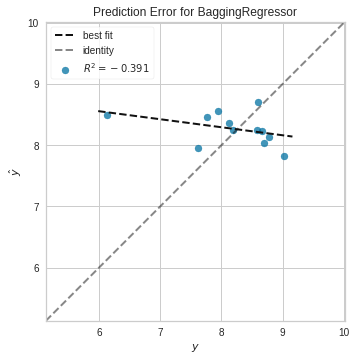

In [0]:
plot_model(tune_lr, plot = 'error')

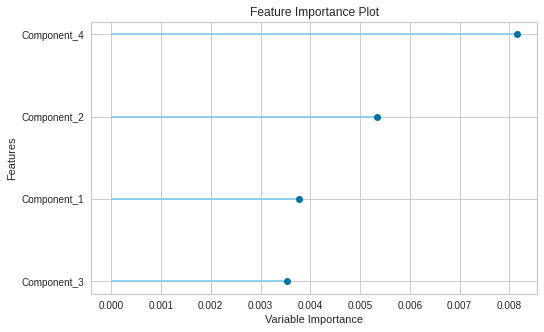

In [0]:
plot_model(lr_model, plot = 'feature')

In [0]:
final_docetaxel = finalize_model(stack_mod)

In [0]:
final_docetaxel

[BaggingRegressor(base_estimator=LinearRegression(copy_X=True,
                                                  fit_intercept=True,
                                                  n_jobs=None, normalize=True),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=50, n_jobs=None, oob_score=False,
                  random_state=123, verbose=0, warm_start=False),
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=123, verbose=0, warm_start=False),
 BaggingRegressor(base_estimator=BayesianRidge(alpha_1=0.

In [0]:
# save a model
save_model(final_docetaxel, 'docetaxel_pca4')

Transformation Pipeline and Model Succesfully Saved


### GSK2126458


In [0]:
exp_regr = setup(data = ExprData.join(DrugsRes.GSK2126458, how = 'outer'), 
                  target = 'GSK2126458', 
                  session_id = 123,
                  normalize = True, 
                  transformation = True, 
                  #ignore_low_variance = True,
                  #remove_multicollinearity = True, 
                  #multicollinearity_threshold = 0.95,
                  pca = True, 
                  pca_components = 5,
                  train_size = 0.78,
                  #ignore_features = ['index'],
                  #feature_selection = True,
                  #feature_selection_threshold = 0.8,
                  silent = True
                  )

 
Setup Succesfully Completed!


In [0]:
compare_models(fold = 5)

In [0]:
lr_model = create_model(
    'lr', 
    fold = 5,
    #ensemble = True,
    #method = 'Bagging'
    )

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.3344  0.1455  0.3814 -0.2185  0.0406  0.0396
1     0.2670  0.0869  0.2948  0.5678  0.0336  0.0345
2     0.4376  0.2775  0.5268  0.3645  0.0558  0.0535
3     0.2356  0.1108  0.3329  0.6119  0.0355  0.0286
4     0.3791  0.1910  0.4370  0.1685  0.0480  0.0468
Mean  0.3307  0.1623  0.3946  0.2988  0.0427  0.0406
SD    0.0734  0.0674  0.0815  0.3031  0.0082  0.0088

In [0]:
tune_lr = tune_model(
    'lr', 
    fold = 5,
    #n_iter = 100,
    ensemble = True,
    method = 'Bagging'
)

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.3227  0.1442  0.3797 -0.2076  0.0403  0.0380
1     0.2597  0.0839  0.2896  0.5828  0.0329  0.0335
2     0.4485  0.2805  0.5296  0.3576  0.0562  0.0548
3     0.2312  0.1116  0.3341  0.6091  0.0355  0.0280
4     0.3763  0.1919  0.4380  0.1644  0.0482  0.0464
Mean  0.3277  0.1624  0.3942  0.3013  0.0426  0.0401
SD    0.0786  0.0691  0.0837  0.3016  0.0085  0.0095

In [0]:
huber_model = create_model(
    'huber', 
    fold = 5,
    #ensemble = True,
    #method = 'Bagging'
    )

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.3165  0.1440  0.3795 -0.2064  0.0401  0.0372
1     0.2610  0.0886  0.2976  0.5596  0.0338  0.0335
2     0.4561  0.2887  0.5373  0.3388  0.0571  0.0559
3     0.2492  0.1152  0.3395  0.5965  0.0364  0.0304
4     0.3603  0.1778  0.4217  0.2258  0.0465  0.0445
Mean  0.3286  0.1629  0.3951  0.3029  0.0428  0.0403
SD    0.0752  0.0696  0.0822  0.2894  0.0083  0.0091

In [0]:
tune_huber = tune_model(
    'huber', 
    fold = 5,
    #n_iter = 100,
    ensemble = True,
    method = 'Bagging'
)

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.3130  0.1402  0.3744 -0.1743  0.0396  0.0368
1     0.2583  0.0856  0.2926  0.5742  0.0333  0.0332
2     0.4587  0.2825  0.5315  0.3530  0.0564  0.0560
3     0.2543  0.1347  0.3670  0.5285  0.0388  0.0305
4     0.3542  0.1724  0.4152  0.2493  0.0457  0.0435
Mean  0.3277  0.1631  0.3962  0.3061  0.0428  0.0400
SD    0.0752  0.0659  0.0784  0.2674  0.0079  0.0091

In [0]:
ridge_model = create_model(
    'ridge', 
    fold = 5,
    #ensemble = True,
    #method = 'Bagging'
    )

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.3344  0.1455  0.3814 -0.2185  0.0406  0.0396
1     0.2670  0.0869  0.2948  0.5678  0.0336  0.0345
2     0.4376  0.2775  0.5268  0.3645  0.0558  0.0535
3     0.2355  0.1108  0.3329  0.6119  0.0355  0.0286
4     0.3791  0.1910  0.4370  0.1685  0.0480  0.0468
Mean  0.3307  0.1623  0.3946  0.2988  0.0427  0.0406
SD    0.0734  0.0674  0.0815  0.3031  0.0082  0.0088

In [0]:
tune_ridge = tune_model(
    'ridge', 
    fold = 5,
    #n_iter = 100,
    ensemble = True,
    method = 'Bagging'
)

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.3223  0.1433  0.3785 -0.2000  0.0401  0.0380
1     0.2606  0.0846  0.2909  0.5792  0.0331  0.0337
2     0.4471  0.2797  0.5289  0.3594  0.0561  0.0546
3     0.2300  0.1106  0.3326  0.6128  0.0353  0.0278
4     0.3763  0.1919  0.4381  0.1644  0.0482  0.0464
Mean  0.3273  0.1620  0.3938  0.3032  0.0426  0.0401
SD    0.0783  0.0689  0.0834  0.2992  0.0085  0.0095

In [0]:
stack_mod = stack_models(estimator_list = [tune_lr, tune_huber, tune_ridge], 
                         fold = 4,
                         meta_model = tune_lr,
                         restack = True
                         )

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.2849  0.1082  0.3289  0.5708  0.0360  0.0348
1     0.2751  0.0887  0.2978  0.3298  0.0332  0.0349
2     0.2630  0.1091  0.3304  0.6947  0.0352  0.0319
3     0.3177  0.1436  0.3789  0.4962  0.0405  0.0380
Mean  0.2852  0.1124  0.3340  0.5229  0.0362  0.0349
SD    0.0203  0.0198  0.0290  0.1321  0.0027  0.0022

In [0]:
blend_mod = blend_models(estimator_list = [tune_lr, tune_huber, tune_ridge], 
                         fold = 4,
                         #meta_model = tune_huber,
                         #restack = True
                         )

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.3345  0.1596  0.3995  0.3667  0.0435  0.0401
1     0.3680  0.2086  0.4567 -0.5768  0.0497  0.0472
2     0.2851  0.1766  0.4202  0.5061  0.0440  0.0339
3     0.4192  0.2382  0.4881  0.1641  0.0524  0.0502
Mean  0.3517  0.1958  0.4411  0.1150  0.0474  0.0428
SD    0.0489  0.0302  0.0340  0.4176  0.0038  0.0063

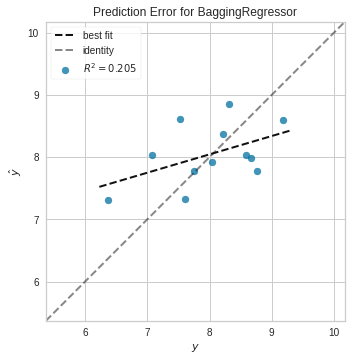

In [0]:
plot_model(tune_lr, plot = 'error')

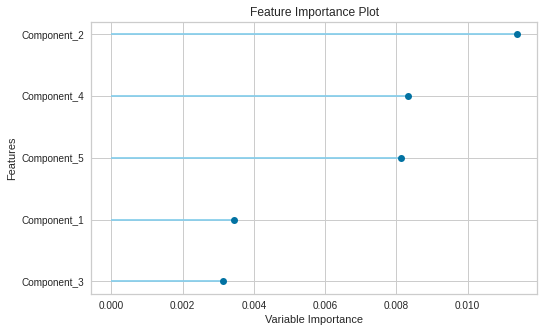

In [0]:
plot_model(lr_model, plot = 'feature')

In [0]:
final_GSK2126458 = finalize_model(stack_mod)

In [0]:
final_GSK2126458

[BaggingRegressor(base_estimator=LinearRegression(copy_X=True,
                                                  fit_intercept=True,
                                                  n_jobs=None, normalize=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=250, n_jobs=None,
                  oob_score=False, random_state=123, verbose=0,
                  warm_start=False),
 BaggingRegressor(base_estimator=HuberRegressor(alpha=0.545, epsilon=1.35,
                                                fit_intercept=True, max_iter=100,
                                                tol=1e-05, warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=50, n_jobs=None, oob_score=False,
                  random_state=123, verbose=0, warm_start=False),
 BaggingRegressor(base_estimator=Ridge(alpha=0.859, copy_X=True,
               

In [0]:
# save a model
save_model(final_GSK2126458, 'GSK2126458_pca5')

Transformation Pipeline and Model Succesfully Saved


### 

### Paclitaxel


In [0]:
exp_regr = setup(data = ExprData.join(DrugsRes.Paclitaxel, how = 'outer'), 
                  target = 'Paclitaxel', 
                  session_id = 123,
                  normalize = True, 
                  transformation = True, 
                  #ignore_low_variance = True,
                  #remove_multicollinearity = True, 
                  #multicollinearity_threshold = 0.95,
                  pca = True, 
                  pca_components = 5,
                  train_size = 0.78,
                  #ignore_features = ['index'],
                  #feature_selection = True,
                  #feature_selection_threshold = 0.8,
                  silent = True
                  )

 
Setup Succesfully Completed!


In [0]:
compare_models(fold = 4)

In [0]:
br_model = create_model(
    'br', 
    fold = 4,
    #ensemble = True,
    #method = 'Bagging'
    )

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.2931  0.1531  0.3913  0.0538  0.0452  0.0385
1     0.1890  0.0536  0.2315  0.1579  0.0257  0.0236
2     0.2544  0.1155  0.3398  0.1811  0.0394  0.0333
3     0.2764  0.1285  0.3584 -0.2249  0.0405  0.0351
Mean  0.2532  0.1127  0.3303  0.0420  0.0377  0.0326
SD    0.0396  0.0367  0.0599  0.1614  0.0073  0.0055

In [0]:
tune_br = tune_model(
    'br', 
    fold = 4,
    #n_iter = 100,
    ensemble = True,
    method = 'Bagging'
)

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.3015  0.1608  0.4010  0.0066  0.0462  0.0394
1     0.1820  0.0514  0.2268  0.1920  0.0251  0.0226
2     0.2553  0.1174  0.3426  0.1677  0.0397  0.0335
3     0.2499  0.1139  0.3374 -0.0858  0.0381  0.0318
Mean  0.2472  0.1109  0.3269  0.0701  0.0373  0.0318
SD    0.0426  0.0390  0.0630  0.1148  0.0077  0.0060

In [0]:
catboost_model = create_model(
    'catboost', 
    fold = 4,
    #ensemble = True,
    #method = 'Bagging'
    )

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.3199  0.1465  0.3827  0.0948  0.0438  0.0415
1     0.2297  0.0699  0.2643 -0.0974  0.0293  0.0288
2     0.2132  0.0733  0.2707  0.4802  0.0309  0.0274
3     0.3095  0.1429  0.3780 -0.3625  0.0426  0.0392
Mean  0.2681  0.1081  0.3239  0.0288  0.0367  0.0342
SD    0.0472  0.0366  0.0565  0.3071  0.0066  0.0062

In [0]:
tune_catboost = tune_model(
    'catboost', 
    fold = 5,
    #n_iter = 100,
    ensemble = True,
    method = 'Bagging'
)

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.2682  0.1344  0.3666 -0.0075  0.0430  0.0362
1     0.2423  0.0721  0.2685 -0.0759  0.0297  0.0300
2     0.2815  0.1278  0.3575  0.3027  0.0406  0.0359
3     0.1763  0.0510  0.2259  0.0454  0.0257  0.0225
4     0.2580  0.1283  0.3582 -0.0150  0.0406  0.0332
Mean  0.2452  0.1027  0.3153  0.0499  0.0359  0.0315
SD    0.0368  0.0344  0.0574  0.1321  0.0069  0.0050

In [0]:
huber_model = create_model(
    'huber', 
    fold = 4,
    #ensemble = True,
    #method = 'Bagging'
    )

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.3278  0.1863  0.4316 -0.1509  0.0496  0.0429
1     0.2043  0.0532  0.2307  0.1635  0.0257  0.0257
2     0.2454  0.1070  0.3271  0.2412  0.0381  0.0323
3     0.2831  0.1254  0.3541 -0.1955  0.0400  0.0362
Mean  0.2651  0.1180  0.3359  0.0146  0.0383  0.0342
SD    0.0457  0.0475  0.0718  0.1904  0.0085  0.0062

In [0]:
tune_huber = tune_model(
    'huber', 
    fold = 4,
    #n_iter = 100,
    ensemble = True,
    method = 'Bagging'
)

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.3116  0.1711  0.4136 -0.0572  0.0476  0.0407
1     0.1816  0.0486  0.2205  0.2361  0.0244  0.0227
2     0.2435  0.1143  0.3381  0.1892  0.0393  0.0321
3     0.2441  0.1116  0.3341 -0.0645  0.0378  0.0312
Mean  0.2452  0.1114  0.3266  0.0759  0.0373  0.0317
SD    0.0460  0.0433  0.0690  0.1378  0.0083  0.0064

In [0]:
stack_mod = stack_models(estimator_list = [tune_br, tune_huber, tune_catboost], 
                         fold = 4,
                         meta_model = tune_huber,
                         restack = True
                         )

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.3056  0.1658  0.4072 -0.0247  0.0469  0.0400
1     0.1801  0.0487  0.2208  0.2343  0.0245  0.0225
2     0.2394  0.1091  0.3303  0.2262  0.0384  0.0315
3     0.2548  0.1154  0.3397 -0.1006  0.0384  0.0325
Mean  0.2450  0.1098  0.3245  0.0838  0.0371  0.0316
SD    0.0448  0.0415  0.0668  0.1489  0.0080  0.0062

In [0]:
blend_mod = blend_models(estimator_list = [tune_br, tune_huber, tune_catboost], 
                         fold = 4,
                         #meta_model = tune_huber,
                         #restack = True
                         )

MAE     MSE    RMSE      R2   RMSLE    MAPE
0     0.3006  0.1581  0.3976  0.0233  0.0458  0.0393
1     0.1830  0.0509  0.2256  0.2007  0.0250  0.0228
2     0.2458  0.1092  0.3304  0.2259  0.0383  0.0322
3     0.2449  0.1113  0.3336 -0.0609  0.0377  0.0312
Mean  0.2436  0.1073  0.3218  0.0972  0.0367  0.0314
SD    0.0416  0.0380  0.0617  0.1201  0.0075  0.0059

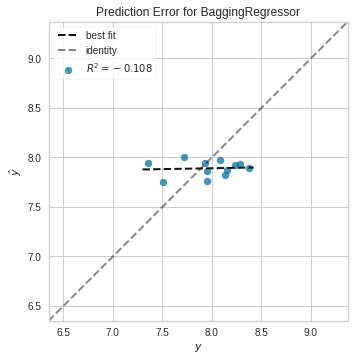

In [0]:
plot_model(tune_br, plot = 'error')

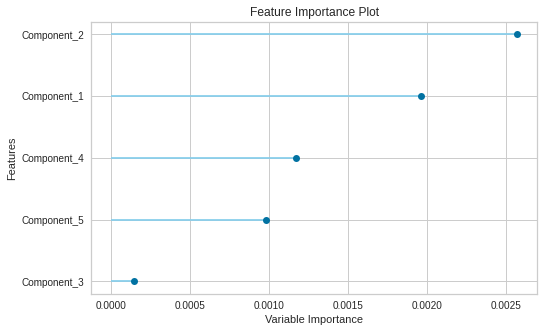

In [0]:
plot_model(br_model, plot = 'feature')

In [0]:
final_Paclitaxel = finalize_model(blend_mod)

In [0]:
final_Paclitaxel

VotingRegressor(estimators=[('Bagging Regressor_0',
                             BaggingRegressor(base_estimator=LinearRegression(copy_X=True,
                                                                              fit_intercept=True,
                                                                              n_jobs=None,
                                                                              normalize=False),
                                              bootstrap=True,
                                              bootstrap_features=False,
                                              max_features=1.0, max_samples=1.0,
                                              n_estimators=250, n_jobs=None,
                                              oob_score=False, random_state=123,
                                              verbose=0, warm_start=False)),
                            ('Bagging Regressor_1',
                             Baggi...
                            ('Ba

In [0]:
# save a model
save_model(final_Paclitaxel, 'Paclitaxel')

Transformation Pipeline and Model Succesfully Saved


### Compare Drug response

In [0]:
DrugsRes[b_drugs].idxmax(axis = 1).head()

184A1    GSK2126458
184B5     Docetaxel
21MT1    GSK2126458
21NT      Docetaxel
21PT     GSK2126458
dtype: object

In [0]:
DrugsRes_best = pd.DataFrame(DrugsRes.index)

In [0]:
b_drugs

['Docetaxel', 'GSK2126458', 'Paclitaxel']

In [0]:
Docetaxel = load_model('/content/Modeling-Precision-Medicine/models/docetaxel_pca4')
Docetaxel_pred = predict_model(Docetaxel, data = ExprData.join(DrugsRes.Docetaxel, how = 'outer'))['Label']
DrugsRes_best['Docetaxel'] = Docetaxel_pred

In [0]:
GSK2126458 = load_model('/content/Modeling-Precision-Medicine/models/GSK2126458_pca5')
GSK2126458_pred = predict_model(GSK2126458, data = ExprData.join(DrugsRes.GSK2126458, how = 'outer'))['Label']
DrugsRes_best['GSK2126458'] = GSK2126458_pred

In [0]:
Paclitaxel = load_model('/content/Modeling-Precision-Medicine/models/Paclitaxel')
Paclitaxel_pred = predict_model(Paclitaxel, data = ExprData.join(DrugsRes.Paclitaxel, how = 'outer'))['Label']
DrugsRes_best['Paclitaxel'] = Paclitaxel_pred

In [0]:
DrugsRes_best = DrugsRes_best.set_index(0)

In [0]:
DrugsRes[b_drugs].idxmax(axis = 1)

## Best Drug selection on regression prediction:

In [0]:
(DrugsRes_best[b_drugs].idxmax(axis = 1) == DrugsRes[b_drugs].idxmax(axis = 1)).sum() / len(DrugsRes)

0.6538461538461539

##Conclusion


Conclusions

These results suggest that matching patients to treatments based on transcriptional subtype will improve response rates, and inclusion of additional features from other profiling data types may provide additional benefit. Further, we suggest a systems biology strategy for guiding clinical trials so that patient cohorts most likely to respond to new therapies may be more efficiently identified.

<img src="https://raw.githubusercontent.com/cappelchi/Modeling-Precision-Medicine/master/img/CellLines_Pub_Fig.jpg" width="600" height="400" />
 

FIGURE:

 



 

Figure 1: Cell line-based response prediction strategy.

(A) We assembled a collection of 84 breast cancer cell lines composed of 35 luminal, 27 basal, 10 claudin-low, 7 normal-like, 2 matched normal and 3 of unknown subtype. Fourteen luminal and 7 basal cell lines were also ERBB2-amplified.

(B) Seventy lines were tested for response to 138 compounds by growth inhibition assays. Compounds with low variation in response in the cell line panel were eliminated, leaving a response data set of 90 compounds. Cell lines were divided into a sensitive and resistant group for each compound using the mean GI50 value for that compound.

(C) Seven pretreatment molecular profiling data sets were analyzed to identify molecular features associated with response. Exome-seq data were available for 75 cell lines, followed by SNP6 data for 74 cell lines, RNAseq for 56, exon array for 56, RPPA for 49, methylation for 47, and U133A expression array data for 46 cell lines. All 70 lines were used in development of at least some predictors depending on data type availability.

(D) Classification signatures were developed using the molecular feature data (after filtering) and with response status as the target. Two methods, weighted least squares support vector machine (LS-SVM) and random forests (RF), were utilized. The best performing signature was chosen for each drug and data type combination. This allows prediction of response for additional cell lines or tumors with any given combination of input data types.

(E) Cell line-based response predictors were applied to 306 TCGA breast tumors for which expression (Exp), copy number (CNV) and methylation (Meth) measurements were all available.

(F) This identified 22 compounds with a model AUC >0.7 for which at least some patients were predicted to be responsive with a probability >0.65. Thresholds for considering a tumor responsive were objectively chosen for each compound from the distribution of predicted probabilities and each patient was assigned to a status of resistant, intermediate or sensitive. WPMV, weighted percent of model variables